# Viewer

This is a viewer were you can see and debug your clicks and annotations.

There are three kinds of visualizations:
- view point in video
- render the interpolated points
- view multiple points
- view gaussians of multiple points

In [1]:
# environment setup
import os
import random

import cv2
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
from matplotlib import rcParams

import seaborn as sns

from helpers.file_loader import file_loader, multiple_file_loader

### Display clicked points in video

shows the clicked points in the video.

In [2]:
class FLAGS:
    video_path = '/data/side_seing/v5_Jundiaí_NovaCidadeJardim-CurbRampConcrete-2024-02-01-16-29-30-587.mp4'
    anntation_path = 'runs/v5_Jundiaí_NovaCidadeJardim-CurbRampConcrete-2024-02-01-16-29-30-587/v5_Jundiaí_NovaCidadeJardim-CurbRampConcrete-2024-02-01-16-29-30-587_1'
    image_path = '/data/side_seing/vlcsnap-2024-04-10-17h47m07s979.png'

In [3]:
# load video using an interator
class VideoIterator:
    def __init__(self, video_path):
        self.video_path = video_path
        self.cap = cv2.VideoCapture(video_path)

    def __iter__(self):
        if not self.cap.isOpened():
            raise StopIteration
        return self

    def __next__(self):
        ret, frame = self.cap.read()
        if not ret:
            self.cap.release()
            raise StopIteration
        return frame
    
    @property
    def current_frame(self):
        return int(self.cap.get(cv2.CAP_PROP_POS_FRAMES))
    
    @property
    def num_frames(self):
        return int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))

def render_single_point(frame, point):
    point = list(map(int, point))
    input_prob = np.zeros(frame.shape)
    input_prob = cv2.circle(input_prob, point, 30, (255,255,255), -1).astype('uint8')
    frame = cv2.addWeighted(input_prob, 0.3, frame, 0.7, 0)
    return frame

In [ ]:
# Iterating through the video frames and click annotations to display it
# this works for a single point
def show_video(clicks: dict, show_all=False):
    """
    Iterate through the video frames and display it. USED FOR INDIVIDUAL USER.

    Args:
        show_all: If False will display only the frames that have clicks. Defaults to False.
    """

    video_iterator = VideoIterator(FLAGS.video_path)
    for frame in video_iterator:

        if not show_all and video_iterator.current_frame not in clicks:
            continue

        point = (clicks[video_iterator.current_frame]['x'], clicks[video_iterator.current_frame]['y'])
        frame = render_single_point(frame, point)
        
        cv2.imshow('Video', frame)
        if cv2.waitKey(27) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()



frame_clicks = file_loader(FLAGS.anntation_path, 'dict')

show_video(frame_clicks)

### Display clicked points and interpolate to fill the missing frames

> observe that here we already consider multiple users annotating the video

In [8]:
class FLAGS:
    video_path = '/data/side_seing/v5_Jundiaí_NovaCidadeJardim-CurbRampConcrete-2024-02-01-16-29-30-587.mp4'
    anntation_path = 'runs/v5_Jundiaí_NovaCidadeJardim-CurbRampConcrete-2024-02-01-16-29-30-587'
    image_path = '/data/side_seing/vlcsnap-2024-04-10-17h47m07s979.png'

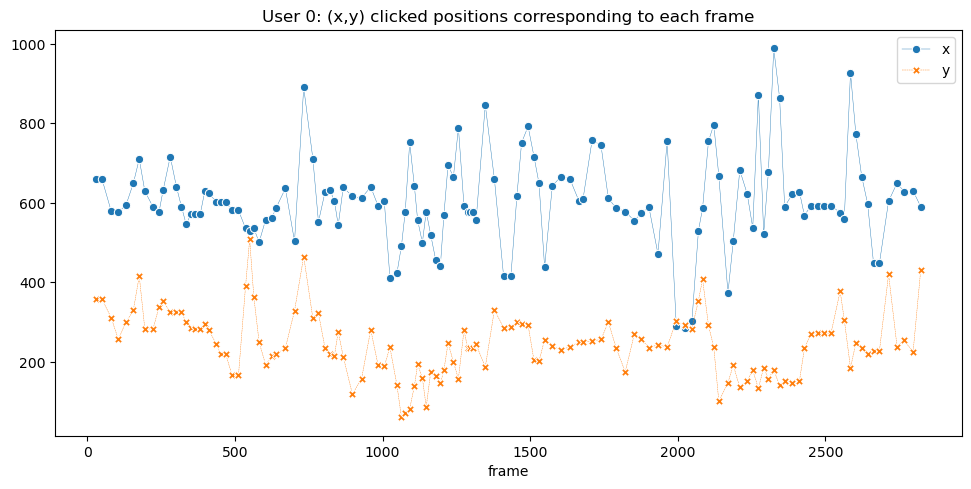

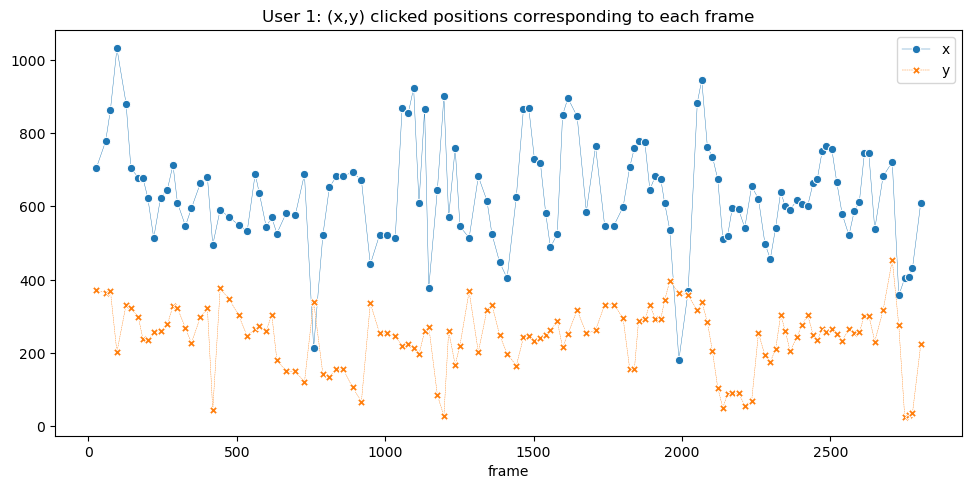

In [23]:
# original click points

frame_clicks = multiple_file_loader(FLAGS.anntation_path)
users = list(frame_clicks['user'].unique())

for user in users:
    user_lines = frame_clicks['user'] == user
    df_user = frame_clicks.loc[user_lines, ['x', 'y']]
    
    rcParams['figure.figsize'] = 11.7,5.27
    sns.lineplot(data=df_user, markers=True, lw=0.3)
    plt.title(f'User {user}: (x,y) clicked positions corresponding to each frame')
    plt.show()

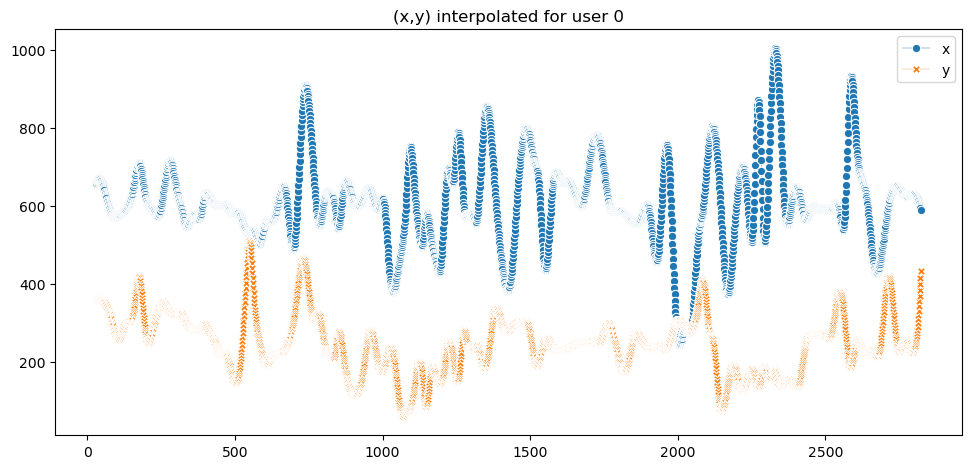

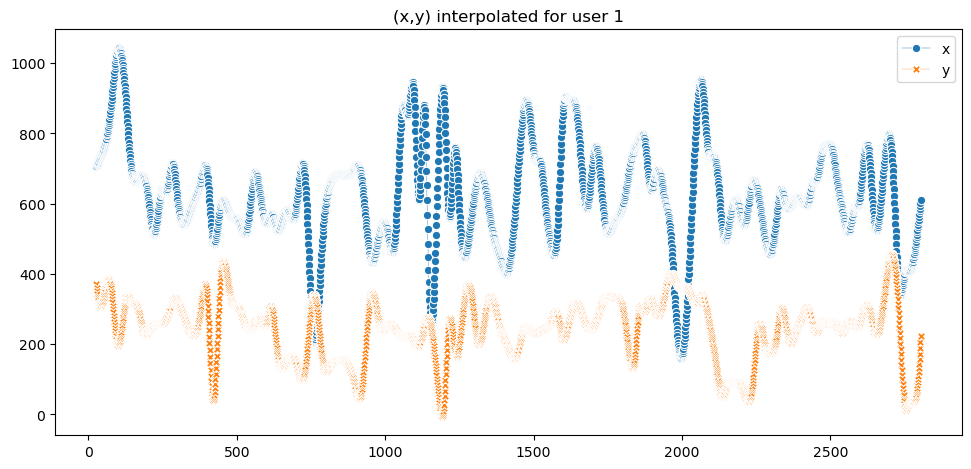

In [31]:
# apply cubic interpolation

def interpolate(df_clicks, user_name=None):

    df_clicks = df_clicks.sort_index()
    all_frames = set(range(df_clicks.index.min(), df_clicks.index.max()))

    x = df_clicks['x'].to_numpy()
    y = df_clicks['y'].to_numpy()
    z = df_clicks.index

    missing_frames = list(all_frames - set(z))

    interpx = interp1d(z, x, kind='cubic')
    interpy = interp1d(z, y, kind='cubic')
    x_interp = interpx(missing_frames)
    y_interp = interpy(missing_frames)

    interpolated_df = pd.DataFrame({
            'x': x_interp,
            'y': y_interp
        }, index=missing_frames)

    interpolated_df = pd.concat([interpolated_df, df_clicks], axis=0).sort_index()

    # plot
    rcParams['figure.figsize'] = 11.7,5.27
    g = sns.lineplot(data=interpolated_df, markers=True, lw=0.3)
    plt.title(f'(x,y) interpolated for user {user_name}')
    plt.show()

    return interpolated_df

frame_clicks = multiple_file_loader(FLAGS.anntation_path)

iterpolated_by_user = {}
users = list(frame_clicks['user'].unique())
for user in users:
    user_lines = frame_clicks['user'] == user
    df_user = frame_clicks.loc[user_lines, ['x', 'y']]
    iterpolated_by_user[user] = interpolate(df_user, user)

### show multiple points


In [ ]:

# this works for many annotations by frame
def render_multiple_points(frame, points):
    pass

def random_colors(num_colors):
    """
    Generate random colors in OpenCV format (BGR).
    """
    return [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(num_colors)]


def show_video_multiple(clicks: pd.DataFrame, show_all=False):
    """
    Iterate through the video frames and display it. USED FOR MULTIPLE USERS.

    Args:
        show_all: If False will display only the frames that have clicks. Defaults to False.
    """

    num_annotators = clicks['user'].max()+1

    video_iterator = VideoIterator(FLAGS.video_path)
    for frame in video_iterator:

        if not show_all and video_iterator.current_frame not in clicks.index:
            continue

        point = list(zip(clicks.loc[video_iterator.current_frame]['x'], clicks[video_iterator.current_frame]['y']))
        frame = render_single_point(frame, point)
        
        cv2.imshow('Video', frame)
        if cv2.waitKey(27) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()


clicks = 
clicks
# show_video_multiple(frame_clicks)

# create blobs

TODO: create a sepparated and independent file to this

In [5]:
import cv2
import numpy as np

def draw_gaussian_blob(image_shape, center_x, center_y, sigma=10):
    # Create a black image
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Create a grid of coordinates
    y, x = np.ogrid[:image_shape[0], :image_shape[1]]

    # Calculate Gaussian distribution
    gaussian = np.exp(-((x - center_x) ** 2 + (y - center_y) ** 2) / (2 * sigma ** 2))

    # Normalize the Gaussian distribution
    gaussian = gaussian / np.max(gaussian)

    # Apply the Gaussian distribution to the circular mask
    mask = (gaussian * 255).astype(np.uint8)

    return mask

# Example usage:
image_shape = (600, 400)  # Shape of the image
center_x, center_y = 150, 150  # Center coordinates of the Gaussian blob
sigma = 30  # Sigma value for Gaussian distribution

# Draw the Gaussian blob mask
gaussian_blob_mask = draw_gaussian_blob(image_shape, center_x, center_y, sigma)

# Display the Gaussian blob mask
cv2.imshow("Gaussian Blob Mask", gaussian_blob_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


QObject::moveToThread: Current thread (0x3f5bdb0) is not the object's thread (0x25abc90).
Cannot move to target thread (0x3f5bdb0)

Qt: Session management error: Could not open network socket
QObject::moveToThread: Current thread (0x3f5bdb0) is not the object's thread (0x25abc90).
Cannot move to target thread (0x3f5bdb0)

QObject::moveToThread: Current thread (0x3f5bdb0) is not the object's thread (0x25abc90).
Cannot move to target thread (0x3f5bdb0)

QObject::moveToThread: Current thread (0x3f5bdb0) is not the object's thread (0x25abc90).
Cannot move to target thread (0x3f5bdb0)

QObject::moveToThread: Current thread (0x3f5bdb0) is not the object's thread (0x25abc90).
Cannot move to target thread (0x3f5bdb0)

QObject::moveToThread: Current thread (0x3f5bdb0) is not the object's thread (0x25abc90).
Cannot move to target thread (0x3f5bdb0)

QObject::moveToThread: Current thread (0x3f5bdb0) is not the object's thread (0x25abc90).
Cannot move to target thread (0x3f5bdb0)

QObject::moveToT